In [1]:
%cd /kaggle/working
%rm -rf /kaggle/working/*

/kaggle/working


In [2]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
import gc
from pathlib import Path
import pickle
from tqdm import tqdm
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pytorch_lightning as pl
from torchmetrics import MetricCollection, MeanSquaredError
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping


sys.path.append('/kaggle/src')
from utils.metric import compute_comptetition_metric
from utils.set_seed import seed_base_torch
from utils.feature_contena import Features
from utils.lightning_utils import MyLightningDataModule
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from consts import ANGLEZ_MEAN, ANGLEZ_STD, ENMO_MEAN, ENMO_STD
from torch_model.dataset import ZzzPatchDataset
from torch_model.gru_model import ZzzConv1dGRUModule

MODEL_NAME = "conv1d_gru_model"

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base_torch(CFG["env"]["seed"])

BLOCK_SIZE = CFG[MODEL_NAME]["execution"]["block_size"]

2023-10-23 19:25:56.111113: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-10-23 19:25:56.112240: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-10-23 19:25:56.112249: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlo

exp_100
rm: cannot remove '/kaggle/output/exp_100': No such file or directory


In [3]:
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
dfs = []
for file in tqdm(files):
    df = pd.read_parquet(file)
    dfs.append(df)
train = pd.concat(dfs, axis=0).reset_index(drop=True)
del dfs
gc.collect()

100%|██████████| 277/277 [00:24<00:00, 11.29it/s]


3078

In [4]:
# 標準化
train["anglez"] = (train["anglez"] - ANGLEZ_MEAN) / ANGLEZ_STD
train["enmo"] = (train["enmo"] - ENMO_MEAN) / ENMO_STD
train["anglez_diff"] = train["anglez"].diff().fillna(0)
train["enmo_diff"] = train["enmo"].diff().fillna(0)

# targetは01にする
train["onset_target"] = train["onset_target"] / 10
train["wakeup_target"] = train["wakeup_target"] / 10

In [5]:
# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

,series_id,step,timestamp,anglez,enmo,event,target,onset_target,wakeup_target,anglez_diff,enmo_diff,fold
0,c3072a759efb,0,2018-02-26T12:15:00-0500,-2.217345,-0.123969,None,1,0.0,0.0,0.000000,0.000000,3
1,c3072a759efb,1,2018-02-26T12:15:05-0500,-2.216284,-0.035560,None,1,0.0,0.0,0.001061,0.088409,3
2,c3072a759efb,2,2018-02-26T12:15:10-0500,-2.121312,-0.124951,None,1,0.0,0.0,0.094972,-0.089391,3
3,c3072a759efb,3,2018-02-26T12:15:15-0500,-2.117824,-0.128880,None,1,0.0,0.0,0.003488,-0.003929,3
4,c3072a759efb,4,2018-02-26T12:15:20-0500,-2.117486,-0.131827,None,1,0.0,0.0,0.000338,-0.002947,3


(127946340, 12)

In [6]:
# BLOCK_SIZE ごとに分割
dfs = []
for series_id, df in tqdm(train.groupby("series_id")):
    df = df.sort_values("step").reset_index(drop=True)

    for start in range(0, len(df), BLOCK_SIZE // 8):
        end = start + BLOCK_SIZE
        if end > len(df):
            # endをlen(df)未満の最大のpsの倍数にする
            end = len(df) - len(df) % CFG[MODEL_NAME]["execution"]["patch_size"]
            start = end - BLOCK_SIZE
            assert start >= 0
        assert df.iloc[start]["step"] % CFG[MODEL_NAME]["execution"]["patch_size"] == 0
        dfs.append(df.iloc[start: end])
gc.collect()

features = Features()
features.add_num_features(["anglez", "enmo"])
features.add_num_features(["anglez_diff", "enmo_diff"])
dataset_oof = ZzzPatchDataset(dfs, 'train', features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"])
feats, targets = dataset_oof[0]
feats.shape, targets.shape

100%|██████████| 277/277 [00:30<00:00,  8.96it/s]


((1600, 48), (1600, 2))

In [7]:
!rm -r logs

rm: cannot remove 'logs': No such file or directory


In [8]:
%%time

fold_oof_dfs = []
for fold in range(5):
    print(f"== fold {fold} ==")
    
    # 学習・評価データ
    train_dfs = [df for df in dfs if df["fold"].unique()[0] != fold]
    valid_dfs = [df for df in dfs if df["fold"].unique()[0] == fold]
    train_dataset = ZzzPatchDataset(train_dfs, mode="train", features=features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"])
    valid_dataset = ZzzPatchDataset(valid_dfs, mode="train", features=features, patch_size=CFG[MODEL_NAME]["execution"]["patch_size"])
    data_module = MyLightningDataModule(train_dataset, valid_dataset, batch_size=32)

    # モデル
    num_training_steps = len(train_dataset) // 32 * 10
    model = ZzzConv1dGRUModule(
        input_numerical_size=len(features.all_features()) * CFG[MODEL_NAME]["execution"]["patch_size"],
        **CFG[MODEL_NAME]["params"],
        lr=0.001, 
        dropout=0.0, 
        loss_fn=nn.BCEWithLogitsLoss(),
        num_training_steps=num_training_steps,
        )
    
    # コールバック
    cp_callback = ModelCheckpoint(
        "logs/", 
        filename=f"best_model_fold{fold}",
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        save_last=False,
    )
    es_callback = EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=8,
    )

    # 学習
    trainer = pl.Trainer(
        callbacks=[cp_callback, es_callback],
        deterministic=True,
        val_check_interval=0.25,
        max_epochs=3,
        )
    trainer.fit(model, datamodule=data_module)

    # 推論
    model = ZzzConv1dGRUModule.load_from_checkpoint(
        f"logs/best_model_fold{fold}.ckpt", 
        input_numerical_size=len(features.all_features()) * CFG[MODEL_NAME]["execution"]["patch_size"],
        **CFG[MODEL_NAME]["params"],
        loss_fn=nn.BCEWithLogitsLoss()).to("cuda")
    model.eval()
    preds = []
    with torch.no_grad():
        for X, y in data_module.val_dataloader():
            pred = torch.sigmoid(model(X.to("cuda"))).detach().cpu().numpy() * 10
            preds.append(pred)

    oof_dfs = []
    for pred, df in zip(np.vstack(preds), valid_dfs):
        df = df.iloc[CFG[MODEL_NAME]["execution"]["patch_size"] // 2: len(df): CFG[MODEL_NAME]["execution"]["patch_size"]].reset_index(drop=True)
        df[["wakeup_oof", "onset_oof"]] = pred
        oof_dfs.append(df)

    oof_df = pd.concat(oof_dfs)
    oof_df = oof_df.groupby(["series_id", "step"]).mean().reset_index().sort_values(["series_id", "step"])
    fold_oof_dfs.append(oof_df[["series_id", "step", "wakeup_oof", "onset_oof"]])

    del model, preds, oof_df, oof_dfs
    gc.collect()
    # break
train = pd.concat(fold_oof_dfs)
train.to_parquet(f"{CFG['output_dir']}/oof.parquet", index=False)
del fold_oof_dfs
gc.collect()

== fold 0 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.7019, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0243, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0215, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0208, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0210, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0206, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0206, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0208, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0212, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0217, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0222, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0226, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0229, 
== fold 1 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.8105, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0209, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0180, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0169, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0172, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0166, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0169, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0169, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0170, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0174, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0176, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0179, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0189, 
== fold 2 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.6771, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0233, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0209, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0211, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0199, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0198, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0198, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0200, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0201, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0208, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0209, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0211, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0215, 
== fold 3 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.5664, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0246, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0227, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0226, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0213, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0218, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0223, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0223, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0219, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0228, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0219, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0234, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0239, 
== fold 4 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.6973, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0241, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0219, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0211, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0212, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0205, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0208, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0208, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0211, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0211, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0215, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0222, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0229, 
CPU times: user 2h 58min 37s, sys: 3min 49s, total: 3h 2min 27s
Wall time: 1h 5min 25s


0

1070499

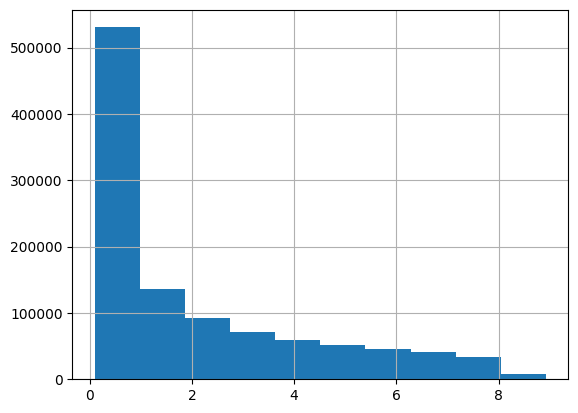

In [9]:
dfs = []
df = train[["series_id", "step", "wakeup_oof"]].copy()
df["event"] = "wakeup"
df["score"] = df["wakeup_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

df = train[["series_id", "step", "onset_oof"]].copy()
df["event"] = "onset"
df["score"] = df["onset_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

train = pd.concat(dfs)
train = train[train["score"]>0.1].reset_index(drop=True)
train["score"].hist()
len(train)

## Dynamic-Range NMS

In [10]:
train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:06<00:00, 43.55it/s]


In [11]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
labels = labels[labels["series_id"].isin(sub["series_id"].unique())]
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

score: 0.7559


event   tolerance
onset   12           0.226047
        36           0.621710
        60           0.723951
        90           0.776409
        120          0.824928
        150          0.845108
        180          0.863803
        240          0.878443
        300          0.884152
        360          0.890425
wakeup  12           0.311543
        36           0.606912
        60           0.713913
        90           0.768021
        120          0.815085
        150          0.838535
        180          0.858981
        240          0.877979
        300          0.891725
        360          0.899409
dtype: float64

In [12]:
%cp -r logs {CFG["output_dir"]}